# Experiment: Gesture Classification with Machine Learning Model

## Overview
In this experiment, we utilized the Linear Discriminant Analysis (LDA) model along with 10 time-domain features extracted from High-Density Electromyography (HDEMG) armband-shaped signals. The goal is to classify gestures using a Machine Learning model. The experiment involves training and validating the model for each subject using a training and validation dataset, while a separate test dataset is used to evaluate the classification performance.

## Signal Preprocessing
The loaded signals undergo a four-step preprocessing pipeline, which includes:
1. Rectification
2. Teager-Kaiser Energy Operator (TKE)
3. Moving Average (30 samples)
4. Normalization

The last step of normalization is applied using the `EMGGestureDataGen` class function. This function is responsible for managing the signal dataset, which is structured as 64 channels, similar to the armband. It applies the specified preprocessing steps and organizes the signal batches for use in machine learning and deep learning methods.

By following this structured preprocessing approach, we aim to enhance the quality of the input data and improve the performance of the classification model.

## Feature Extraction
For the machine learning approach, we use the `FeaturesDataGenerator` to extract 10 features in the time domain from the preprocessed signals.

The chosed features provide valuable information about the signals and will be used as input to the machine learning model.

By following this structured preprocessing and feature extraction approach, we aim to enhance the quality of the input data and improve the performance of the classification model.

## Table of Contents

- [0. Packages](#0)
    - [Custom packages](#0-1)
    - [Pythom packages](#0-2)
- [1. Dataloader's configuration](#1)
- [2. Machine Learning Model](#3)
    - [Linear Discriminant Analysis](#3-1)
- [4. Perfomance Results](#4)
- [5. Salve the model](#5)

<a name="0"></a>
### Packages

<a name="0-1"></a>
#### Custom packages

In [1]:
import os, sys
processing_source_path = os.path.abspath('./../../../Processing/')
if(processing_source_path not in sys.path):
    sys.path.append(processing_source_path)
import ProcessingPipeline as pp

dataloader_source_path = os.path.abspath('./../../../Dataloader/')
if(dataloader_source_path not in sys.path):
    sys.path.append(dataloader_source_path)
from EMGGestureDataGen import EMGGestureDataGen

from FeaturesDataGenerator import FeaturesDataGenerator

dataloader_source_path = os.path.abspath('./../../../Utils/')
if(dataloader_source_path not in sys.path):
    sys.path.append(dataloader_source_path)
import utils

import available_metrics as metrics

<a name="0-2"></a>
#### Pythom packages

In [2]:
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Manipulation
import pandas as pd
import numpy as np

# File and Data Storage
from os.path import join
import datetime
import json
import time
import pickle

# Machine Learning and Metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

# Miscellaneous and Warnings
import warnings
warnings.simplefilter("ignore", UserWarning)


In [3]:
import tensorflow as tf
print(tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
policy = tf.keras.mixed_precision.Policy('float32')
tf.keras.mixed_precision.set_global_policy(policy)

2.8.0
1 Physical GPUs, 1 Logical GPUs


2023-11-28 18:41:34.268275: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 18:41:34.779606: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 69911 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0


<a name="1"></a>
### Dataloader's configuration

In [4]:
data_params = {
    "subjects": "25295225.hdf5",
    "h5_file_path": '/root/data/data/65HD_gestures_comparison2',
    "dataset_name": '65-HD-sEMG',
    "gesture_list": [0,13,14,17,20,36,58,59,63,64],
    "num_emg_channels": 128,
    "sessions":2
}

model_params = {
    'IA_Technique': 'Machine Learning', 
    "model_output_mode": 'multiclass',
    "Models_name": ['LDA'],
    "n_voting": 3,
    "norm_axis": 1,
}

training_params = {
    "using_armband": True,
    "GPU": True,
    "window_size": 128,
    "window_step": 64,
    "batch_size": 1,
}

feature_params = {
    'norm_axis': 1,
    'features_norm_axis': 1,
    'selected_features': ['var', 'dasdv', 'iemg', 'auc', 'rms', 'mav', 'cog', 'dvar', 'danv', 'active_electrodes'],
}

# Combine all categories into a single dictionary
params = {**data_params, **model_params, **training_params, **feature_params}

In [5]:
import h5py
with h5py.File(params['h5_file_path']+'/train/'+ params['subjects'], 'r') as hf:
        params['sessions']=int(np.max(hf['sessions'][:]))
        print('Number of recorded sessions:',params['sessions'])
del hf

Number of recorded sessions: 0


In [6]:
data_processing = pp.ProcessingPipeline([
    pp.NormMinMax(params['norm_axis'])
])

train_dataset = EMGGestureDataGen(params['h5_file_path']+'/train/', params['batch_size'],
                                  params['window_size'], params['window_step'], params['num_emg_channels'], 
                                  shuffle=True, processing=data_processing,
                                  armband=params['using_armband'], model_output_mode=params['model_output_mode'], 
                                  dataset_name=params['dataset_name'], subjects=params['subjects'])

val_dataset = EMGGestureDataGen(params['h5_file_path']+'/val/', params['batch_size'],
                                params['window_size'], params['window_step'], params['num_emg_channels'], 
                                shuffle=True, processing=data_processing,
                                armband=params['using_armband'], model_output_mode=params['model_output_mode'], 
                                dataset_name=params['dataset_name'], subjects=params['subjects'])

test_dataset = EMGGestureDataGen(params['h5_file_path']+'/test/', params['batch_size'],
                                  params['window_size'], params['window_step'], params['num_emg_channels'], processing=data_processing,
                                  shuffle=False, armband=params['using_armband'], model_output_mode=params['model_output_mode'], 
                                  dataset_name=params['dataset_name'], subjects=params['subjects'])

In [7]:
print('(bach size, num_channels, window size')
test_dataset.__getitem__(0)[0].shape

(bach size, num_channels, window size


(1, 64, 128)

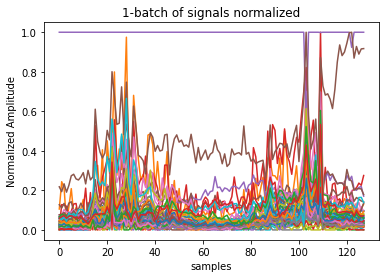

In [8]:
plt.plot(np.hstack(test_dataset.__getitem__(0)[0]).T)
plt.title('1-batch of signals normalized')
plt.xlabel('samples')
plt.ylabel('Normalized Amplitude')
plt.show()

#### Data generator to extract time features

In [9]:
# for EMGConv2DMultiClassModel
data_processing = pp.ProcessingPipeline([
    pp.NormMinMax(params['features_norm_axis']),
    ])

In [10]:
# get features from train_dataset, val_dataset and test_dataset
train_dataset_features=FeaturesDataGenerator(train_dataset, axis=2,processing=data_processing, selected_features=params['selected_features'])
val_dataset_features=FeaturesDataGenerator(val_dataset, axis=2,processing=data_processing, selected_features=params['selected_features'])
test_dataset_features=FeaturesDataGenerator(test_dataset, axis=2, processing=data_processing, selected_features=params['selected_features'])

In [11]:
train_dataset[0][0][0].shape

(64, 128)

In [12]:
print("shape: (batchsize, numfeatures, n_chanels)")
print(train_dataset_features.__getitem__(1)[0].shape)

shape: (batchsize, numfeatures, n_chanels)
(1, 10, 64)


/root/IA-Algorithms-main/fx_bios_ia/EMG/Dataloader/FeaturesDataGenerator.py:121: RuntimeWarning: divide by zero encountered in log
  'LOG': np.exp(np.mean(np.log(emg_data),axis=self.axis)),


In [13]:
# use datasets to get all features of all data and comput the average time to do it 

data_train, labels_train=train_dataset_features.__getAllData__(verbose=1)

 14%|█▍        | 596/4289 [00:01<00:09, 407.16it/s]/root/IA-Algorithms-main/fx_bios_ia/EMG/Dataloader/FeaturesDataGenerator.py:121: RuntimeWarning: invalid value encountered in log
  'LOG': np.exp(np.mean(np.log(emg_data),axis=self.axis)),
100%|██████████| 4289/4289 [00:10<00:00, 403.89it/s]

Average time required to extract features  0.001457539102808249


In [14]:
data_val, labels_val=val_dataset_features.__getAllData__(verbose=1)

100%|██████████| 2301/2301 [00:05<00:00, 406.06it/s]

Average time required to extract features  0.0014580226576571774


In [15]:
data_test, labels_test=test_dataset_features.__getAllData__(verbose=1)

100%|██████████| 2253/2253 [00:05<00:00, 409.11it/s]

Average time required to extract features  0.0014400595408040472


In [16]:
#### Use the train data and val data to train the model for each subject
data_train= np.append(data_train,data_val,axis=0)
labels_train=np.append(labels_train,labels_val,axis=0)

In [17]:
extracted_featues= train_dataset_features.__getFeaturesName__()
print('Used Features:',extracted_featues)

Used Features: ['var', 'dasdv', 'iemg', 'auc', 'rms', 'mav', 'cog', 'dvar', 'danv', 'active_electrodes']


<a name="3"></a>
### Machine Learning Model

<a name="3-1"></a>
#### Linear Discriminant Analysis

In [18]:
#Load the model 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

##### Train the model

In [19]:
model_lda = LinearDiscriminantAnalysis()

start_time=time.time()
model_lda.fit(data_train, labels_train) # train the model with the train+val data that are included in data_train

time_to_train_lda=(time.time() -start_time)
print('Time required to train the Model:', round(time_to_train_lda,3),'s')

Time required to train the Model: 1.016 s


<a name="4"></a>
### Perfomance Result

<a name="4-1"></a>
### Using K-fold (n=5) with all dataset

In [20]:
from sklearn.model_selection import cross_val_score

In [21]:
lda_kflod = LinearDiscriminantAnalysis()
k_fold = 5
scores = cross_val_score(lda_kflod, 
                         np.append(data_train,data_test,axis=0), 
                         np.append(labels_train,labels_test,axis=0), 
                         cv=k_fold)

In [22]:
print("Scores for each Fold:", scores)
print("mean score:", scores.mean())

Scores for each Fold: [0.99773884 0.99491238 0.98812889 0.99377828 0.99547511]
mean score: 0.994006699083512


<a name="4-2"></a>
### Train Dataset

In [23]:
labels_train_predicted = model_lda.predict(data_train)

In [24]:
pr, re, f1, acc=metrics.model_metrics(params['gesture_list'] ,labels_train, labels_train_predicted, Get_metrics=True) 
metrics_list_lda=[pr, re, f1, acc]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2409
          13       1.00      1.00      1.00       433
          14       1.00      1.00      1.00       462
          17       1.00      1.00      1.00       447
          20       0.98      1.00      0.99       579
          36       1.00      1.00      1.00       441
          58       1.00      1.00      1.00       480
          59       1.00      1.00      1.00       471
          63       0.99      1.00      1.00       437
          64       1.00      0.99      1.00       431

    accuracy                           1.00      6590
   macro avg       1.00      1.00      1.00      6590
weighted avg       1.00      1.00      1.00      6590

Precision Score:  0.9970793916320566
Recall Score:  0.9984069714161607
F1-Score:  0.9977289169663237
Accuracy:  0.9975720789074355


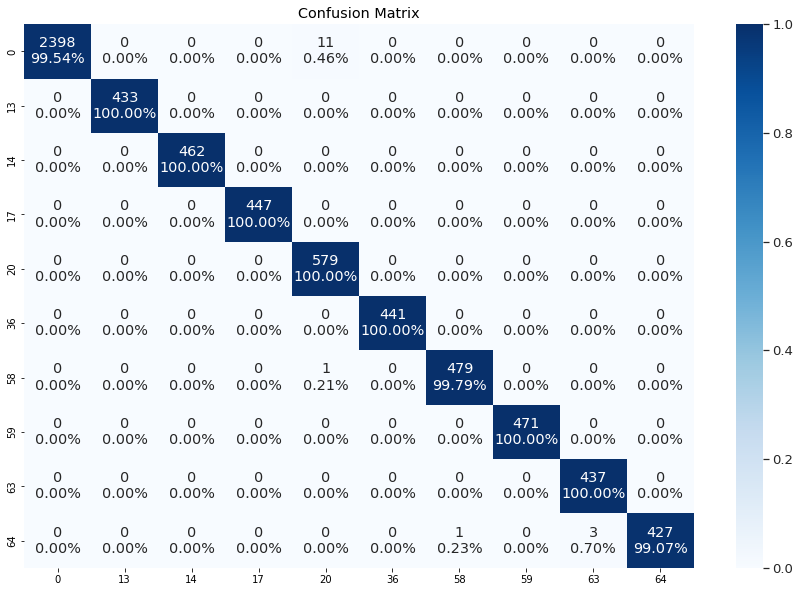

In [25]:
# available the testl data 
cfm_lda=metrics.plot_confusion_matrix(params['gesture_list'], labels_train, labels_train_predicted, Get_matrix=True)

<a name="4-1"></a>
### Test Dataset

In [26]:
labels_test_predicted = model_lda.predict(data_test)

#### Summary model perfomance metrics

In [27]:
pr, re, f1, acc=metrics.model_metrics(params['gesture_list'] ,labels_test, utils.majority_voting(labels_test_predicted,params['n_voting']), Get_metrics=True) 
metrics_list_lda=[pr, re, f1, acc]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1293
          13       0.99      0.99      0.99       114
          14       0.99      0.99      0.99        98
          17       0.99      0.99      0.99       112
          20       0.99      0.99      0.99        85
          36       0.99      0.99      0.99       111
          58       0.99      0.99      0.99       111
          59       0.99      0.99      0.99       100
          63       0.95      0.99      0.97       116
          64       1.00      0.95      0.97       113

    accuracy                           0.99      2253
   macro avg       0.99      0.99      0.99      2253
weighted avg       0.99      0.99      0.99      2253

Precision Score:  0.988195311882729
Recall Score:  0.9870594658425927
F1-Score:  0.9875117552836972
Accuracy:  0.9937860630270751


#### Confusion Matrix

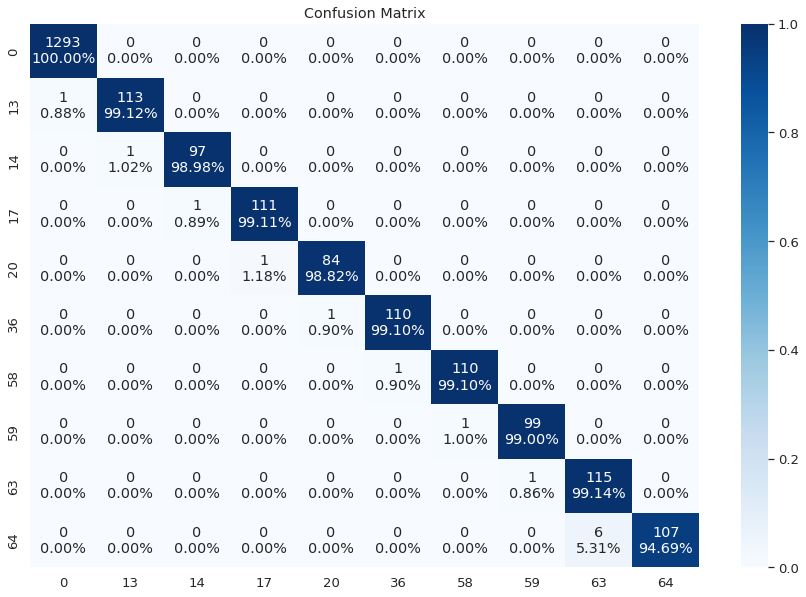

In [28]:
# available the testl data 
cfm_lda=metrics.plot_confusion_matrix(params['gesture_list'], labels_test, utils.majority_voting(labels_test_predicted,params['n_voting']), Get_matrix=True)

#### Accuracy and std for each classes

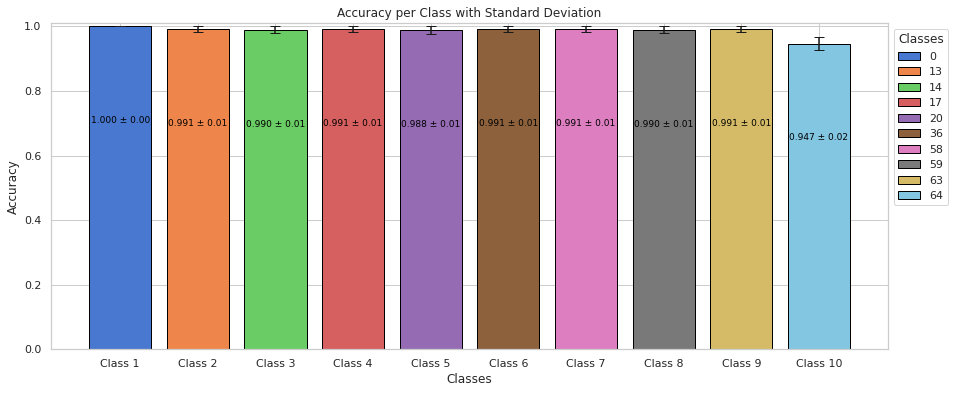

In [29]:
metrics.plot_metric_per_class(cfm_lda, params['gesture_list'], metric_name='Accuracy', method='per_class')

#### Mean and std for all Classes 

In [30]:
metrics_per_class,precision_list,recall_list,f1_score_list,accuracy_list=metrics.model_average_std_metrics(cf_matrix=cfm_lda, Get_metrics=True, Verbose=True) 

Precision Score: 0.9882±0.0131
Recall Score: 0.9871±0.0137
F1-Score: 0.9875±0.0085
Accuracy: 0.9871±0.0137


In [31]:
metrics_average_and_std_df=pd.DataFrame(data=[precision_list,recall_list,f1_score_list,accuracy_list],
             index=['pr', 're', 'f1', 'acc'],
             columns=['Average','std'])
metrics_average_and_std_df

,Average,std
pr,0.988195,0.013143
re,0.987059,0.013713
f1,0.987512,0.008475
acc,0.987059,0.013713


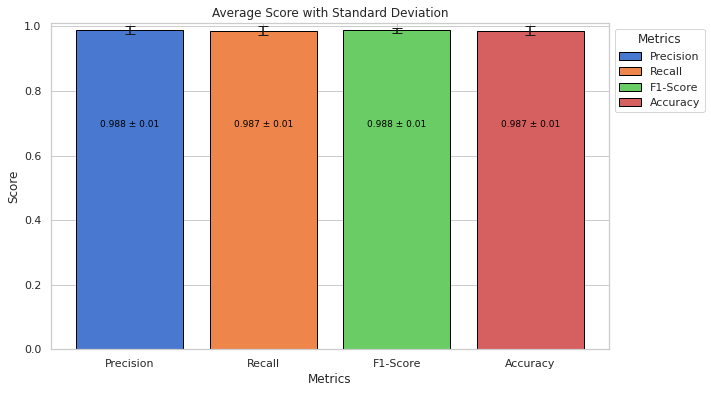

In [32]:
metrics.plot_metric_per_class(cfm_lda, params['gesture_list'], metric_name='All', method='All', figsize=(10,6))

## ROC

ROC AUC for Class 0: 0.99948
ROC AUC for Class 1: 0.99538
ROC AUC for Class 2: 0.99467
ROC AUC for Class 3: 0.99530
ROC AUC for Class 4: 0.99389
ROC AUC for Class 5: 0.99526
ROC AUC for Class 6: 0.99526
ROC AUC for Class 7: 0.99477
ROC AUC for Class 8: 0.99429
ROC AUC for Class 9: 0.97345


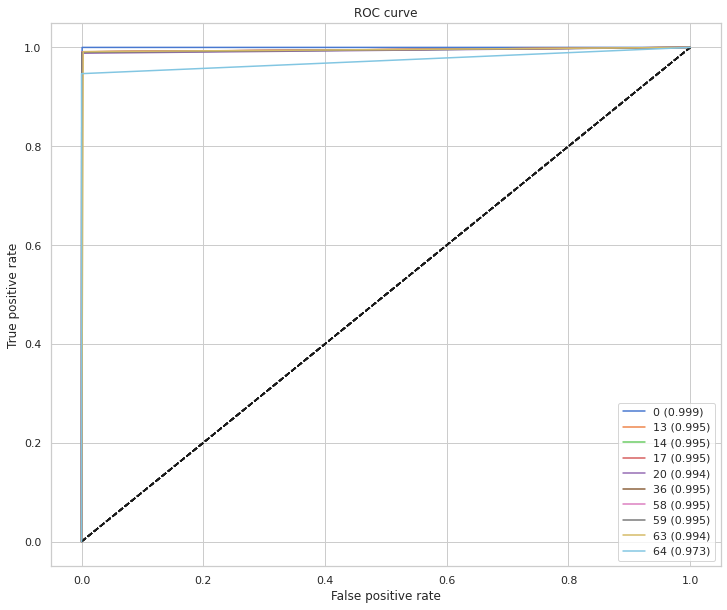

In [33]:
roc_score_per_class=metrics.get_roc_curve(params['gesture_list'], labels_test, utils.majority_voting(labels_test_predicted,params['n_voting']),verbose=True)

#### Principal Components Analysis (PCA) 

In [34]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

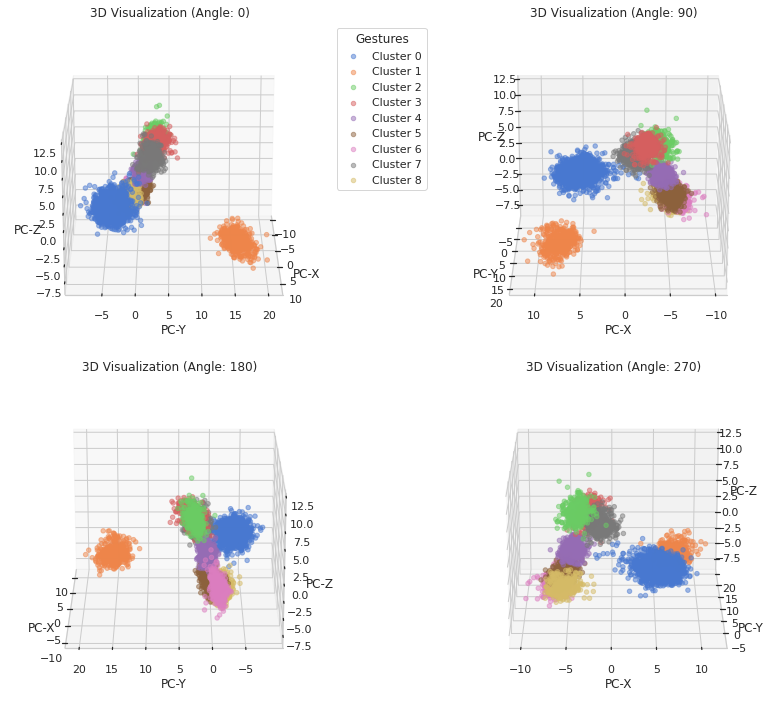

In [35]:
pca = PCA(n_components=3)
X_pca=pca.fit_transform(model_lda.transform(data_train))

# Configuração dos subplots
fig_pca = plt.figure(figsize=(12, 10))

# Configuração de ângulos
angles = [0, 90, 180, 270]

for i, angle in enumerate(angles, start=1):
    ax = fig_pca.add_subplot(2, 2, i, projection='3d')

    # Configure a visão para o ângulo atual
    ax.view_init(elev=20, azim=angle)

    # Plot cada cluster com uma cor diferente
    for j in range(9):
        cluster_points = X_pca[labels_train == j]
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], label=f'Cluster {j}', alpha=0.5)

    ax.set_xlabel('PC-X')
    ax.set_ylabel('PC-Y')
    ax.set_zlabel('PC-Z')
    ax.set_title(f'3D Visualization (Angle: {angle})')

    if i == 1:
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Gestures')

# Ajusta o layout para evitar sobreposição
plt.tight_layout()
plt.savefig('3d_scatter_plot.png')
plt.show()

<a name="5"></a>
### Save the model and params

In [36]:
subject=params['subjects']
# save JSON or model's params
with open(f'trainnings/model_LDA_{subject}', 'wb') as file:
    pickle.dump(model_lda, file)
    
# save JSON or model's params
json_filename=f'trainnings/model_LDA_{subject}_params.json'
with open(json_filename, 'w') as json_file:
    json.dump(params, json_file, indent=4)

print(f'Saving model params in JSON: {json_filename}')
#print(json_parameters)

Saving model params in JSON: trainnings/model_LDA_25295225.hdf5_params.json


<a name="6"></a>
### Save Experiment in mlflow

In [37]:
from mlflow.tracking import MlflowClient
import mlflow
import sys
import shutil

experiment_name = 'test log params'

def save_in_mlflow(params, cfm_lda=None, fig_pca=None, roc_score_per_class=None):
    # Set the tracking URI to a local directory
    sys.path.append('/root/IA-Algorithms-main/mlruns')
    mlflow.set_tracking_uri("file:/root/IA-Algorithms-main/mlruns")

    mlflow.set_experiment(experiment_name)
    experiment = mlflow.get_experiment_by_name(experiment_name)
    
    with mlflow.start_run(experiment_id=experiment.experiment_id):
        # Log data_params
        mlflow.log_param('subjects', params['subjects'])
        mlflow.log_param('h5_file_path', params['h5_file_path'])
        mlflow.log_param('dataset_name', params['dataset_name'])
        mlflow.log_param('gesture_list', params['gesture_list'])
        mlflow.log_param('num_emg_channels', params['num_emg_channels'])
        mlflow.log_param('sessions', params['sessions'])
        
        # Log training_params
        mlflow.log_param('using_armband', params['using_armband'])
        mlflow.log_param('GPU', params['GPU'])
        mlflow.log_param('window_size', params['window_size'])
        mlflow.log_param('window_step', params['window_step'])
        mlflow.log_param('batch_size', params['batch_size'])
        
        # Log model_params
        mlflow.log_param('IA_Technique', params['IA_Technique'])
        mlflow.log_param('model_output_mode', params['model_output_mode'])
        mlflow.log_param('Models_name', params['Models_name'][0])
        mlflow.log_param('n_voting', params['n_voting'])
        mlflow.log_param('norm_axis', params['norm_axis'])
        
        # Log feature_params
        mlflow.log_param('norm_axis', params['norm_axis'])
        mlflow.log_param('features_norm_axis', params['features_norm_axis'])
        mlflow.log_param('selected_features', params['selected_features'])
        
        if roc_score_per_class is not None:
            # Log ROC values per class
            mlflow.log_param('ROC_AUCs', list(roc_score_per_class))
            
        if cfm_lda is not None:
            # Log confusion matrix values
            mlflow.log_param("confusion_matrix", cfm_lda.tolist())

        if os.path.exists(fig_pca):
            mlflow.log_artifact(fig_pca, artifact_path='images')
            os.remove(fig_pca)
            mlflow.log_param('features_pca_name', fig_pca)

In [38]:
save_in_mlflow(params,cfm_lda,'3d_scatter_plot.png', roc_score_per_class)